In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
%matplotlib inline

##  Forecasting Bike Sharing Usage

we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


In [4]:
traindf = pd.read_csv('Homework/HW3/Bikeshare_train.csv').drop('Unnamed: 0',axis = 1)
testdf = pd.read_csv('Homework/HW3/Bikeshare_test.csv').drop('Unnamed: 0',axis = 1)

In [5]:
traindf.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


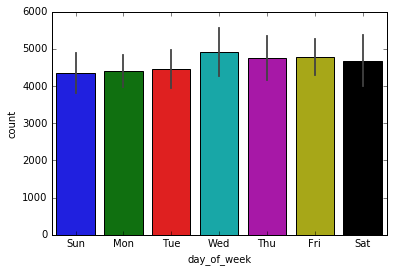

In [7]:
ax = sns.barplot(x= 'day_of_week',y = 'count',data = traindf)
ax.set_xticklabels('Sun-Mon-Tue-Wed-Thu-Fri-Sat'.split('-'))

[<matplotlib.text.Text at 0xc202c88>, <matplotlib.text.Text at 0xc92b828>]

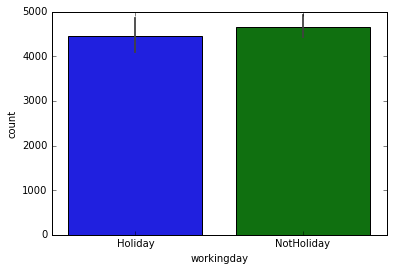

In [8]:
ax = sns.barplot(x= 'workingday',y = 'count',data = traindf)
ax.set_xticklabels('Holiday-NotHoliday'.split('-'))

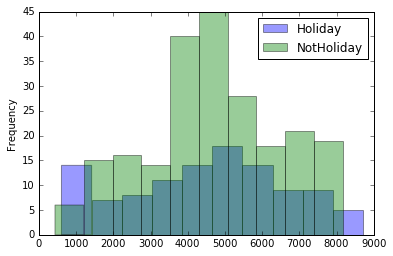

In [9]:
lables = 'Holiday-NotHoliday'.split('-')
for g, group in traindf.groupby('workingday'):
    ax = group['count'].plot(kind='hist',alpha=0.4,label = lables[int(g)])
ax.legend(loc='best')

In [10]:
traindf.groupby('workingday').describe()['count']

workingday       
0.0         count     109.000000
            mean     4461.073394
            std      2144.505359
            min       605.000000
            25%      2732.000000
            50%      4660.000000
            75%      6041.000000
            max      8714.000000
1.0         count     222.000000
            mean     4665.896396
            std      1825.229911
            min       431.000000
            25%      3718.500000
            50%      4621.000000
            75%      5873.750000
            max      8167.000000
Name: count, dtype: float64

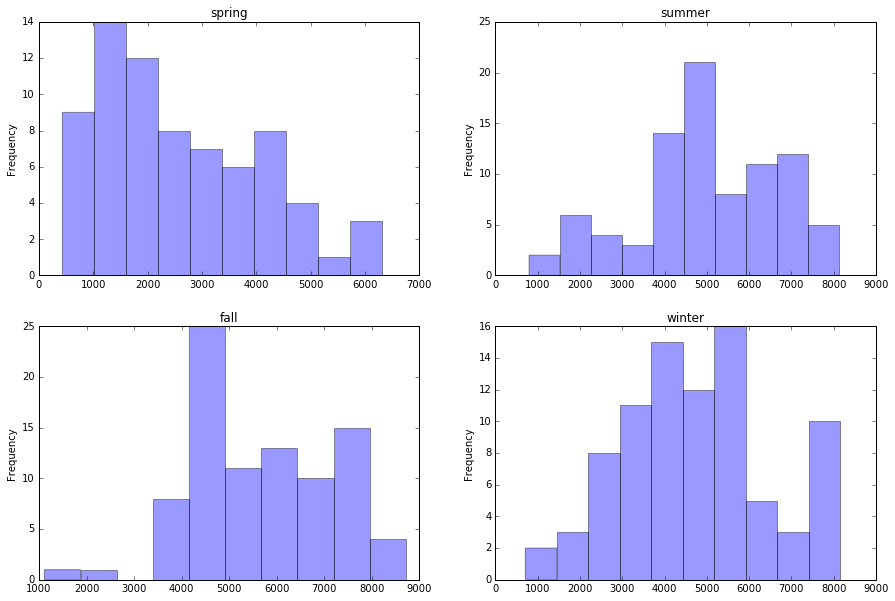

In [11]:
label = 'spring=summer=fall=winter'.split('=')
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.ravel()
for g, group in traindf.groupby('season'):
    i = int(g) - 1
    group['count'].plot(kind='hist',ax=ax[i],alpha=0.4)
    ax[i].set_title(label[i])

In [12]:
traindf['rain/snow'] = traindf['weather'].apply(lambda x: 1 if int(x) in [3,4] else 0)
testdf['rain/snow'] = testdf['weather'].apply(lambda x: 1 if int(x) in [3,4] else 0)

[<matplotlib.text.Text at 0xd9d9278>, <matplotlib.text.Text at 0xd9e3828>]

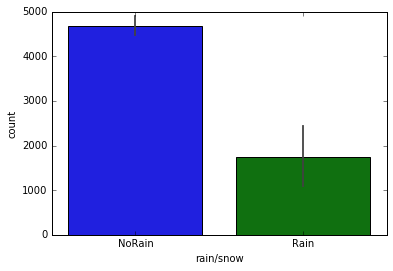

In [13]:
ax = sns.barplot(x= 'rain/snow',y = 'count',data = traindf)
ax.set_xticklabels('NoRain-Rain'.split('-'))

In [14]:
traindf.groupby('rain/snow')[['count']].describe()

count
rain/snow                   
0         count   321.000000
          mean   4687.613707
          std    1886.625924
          min     431.000000
          25%    3620.000000
          50%    4687.000000
          75%    6034.000000
          max    8714.000000
1         count    10.000000
          mean   1736.200000
          std    1179.971544
          min     506.000000
          25%     853.000000
          50%    1646.000000
          75%    1951.250000
          max    4459.000000

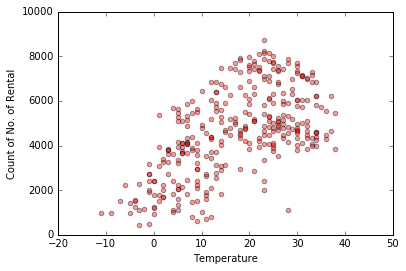

In [15]:
plt.ylabel('Count of No. of Rental')
plt.xlabel('Temperature')
plt.scatter(traindf['temp'].values, traindf['count'].values, alpha=0.4 , c='r')

In [16]:
category_columns = ['season','month','day_of_week','weather']
non_category_columns = ['holiday','workingday','temp','atemp','humidity','windspeed','count']
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']

In [17]:
traindf = pd.get_dummies(traindf, columns=category_columns, drop_first=True)
testdf = pd.get_dummies(testdf, columns=category_columns, drop_first=True)

In [18]:
traindf = traindf.drop('rain/snow',axis = 1)
testdf = testdf.drop('rain/snow',axis = 1)
traindf.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
0,0.0,1.0,24.0,26.0,76.5833,0.118167,6073.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.0,58.6250,0.169779,2431.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,23.0,23.0,91.7083,0.097021,1996.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [19]:
#Normalization
mean_traindf = traindf[numerical_columns].mean()
std_traindf = traindf[numerical_columns].std()
mean_traindf

temp         17.018127
atemp        19.543807
humidity     63.385776
windspeed     0.190833
dtype: float64

In [20]:
traindf[numerical_columns] = (traindf[numerical_columns] - mean_traindf)/std_traindf
testdf[numerical_columns] = (testdf[numerical_columns] - mean_traindf)/std_traindf

#### Linear regression

In [21]:
X_train = sm.add_constant(traindf.drop('count', axis=1))
X_test = sm.add_constant(testdf.drop('count', axis=1))
y_train = traindf['count'].values.reshape(-1,1)
y_test = testdf['count'].values.reshape(-1,1)
model_reg = OLS(y_train,X_train).fit()
y_train_pred = model_reg.predict(X_train)
y_test_pred = model_reg.predict(X_test)
print 'train r2 = ', r2_score(traindf['count'], y_train_pred)
print 'test r2 = ', r2_score(testdf['count'], y_test_pred)

train r2 =  0.576128178313
test r2 =  0.249342111465


In [22]:
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           6.56e-42
Time:                        18:57:16   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const            3681.7765    433.655      8.490      0.000      2828.419  4535.134
holiday          -284.3563    398.982     -0.713      0.477     -1069.483   500.770
workingday        308.1531    165.413      1.863      0.063       -17.351   633.657
temp              925.7338    474.536      1.951      0.052        -8.070  1859.538
atemp             312.4341    429.987      0.727      0.468      -533.705  1158.573
humidity         -548.4929    113.200     -4.845      0.000      -771.251  -325.735
windspeed        -255.1226     80.766     -3.159      0.002      -414.057   -96.189
season_2.0        898.8290    487.802      1.843      0.066       -61.079  1858.737
season_3.0       1032.8816    567.827      1.819      0.070       -84.503  2150.266
season_4.0       1226.1865    506.763      2.420      0.016       228.966  2223.407
month_2.0          88.9401    397.048      0.224      0.823      -692.381   870.262
month_3.0         239.1809    446.873      0.535      0.593      -640.188  1118.549
month_4.0         333.3491    675.444      0.494      0.622      -995.806  1662.504
month_5.0         -65.8125    726.311     -0.091      0.928     -1495.065  1363.440
month_6.0        -792.2629    749.803     -1.057      0.292     -2267.744   683.218
month_7.0       -1279.9870    816.047     -1.569      0.118     -2885.824   325.850
month_8.0        -776.4755    794.782     -0.977      0.329     -2340.467   787.516
month_9.0         405.1446    694.714      0.583      0.560      -961.931  1772.220
month_10.0        486.2509    651.713      0.746      0.456      -796.206  1768.708
month_11.0        112.6816    621.610      0.181      0.856     -1110.538  1335.902
month_12.0       -118.8358    505.353     -0.235      0.814     -1113.282   875.611
day_of_week_1.0  -123.7515    170.981     -0.724      0.470      -460.212   212.709
day_of_week_2.0  -195.2859    203.703     -0.959      0.338      -596.137   205.565
day_of_week_3.0   170.5113    213.789      0.798      0.426      -250.187   591.210
day_of_week_4.0    61.2560    206.213      0.297      0.767      -344.536   467.048
day_of_week_5.0   111.0669    198.877      0.558      0.577      -280.288   502.422
day_of_week_6.0   465.1450    269.154      1.728      0.085       -64.504   994.794
weather_2.0       -16.5666    210.139     -0.079      0.937      -430.083   396.949
weather_3.0     -1581.9783    529.223     -2.989      0.003     -2623.396  -540.560
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     2.22e+15


In [23]:
#for alpha 0.05
model_reg.pvalues<0.05

const               True
holiday            False
workingday         False
temp               False
atemp              False
humidity            True
windspeed           True
season_2.0         False
season_3.0         False
season_4.0          True
month_2.0          False
month_3.0          False
month_4.0          False
month_5.0          False
month_6.0          False
month_7.0          False
month_8.0          False
month_9.0          False
month_10.0         False
month_11.0         False
month_12.0         False
day_of_week_1.0    False
day_of_week_2.0    False
day_of_week_3.0    False
day_of_week_4.0    False
day_of_week_5.0    False
day_of_week_6.0    False
weather_2.0        False
weather_3.0         True
dtype: bool

In [24]:
model_reg.params == 0


const              False
holiday            False
workingday         False
temp               False
atemp              False
humidity           False
windspeed          False
season_2.0         False
season_3.0         False
season_4.0         False
month_2.0          False
month_3.0          False
month_4.0          False
month_5.0          False
month_6.0          False
month_7.0          False
month_8.0          False
month_9.0          False
month_10.0         False
month_11.0         False
month_12.0         False
day_of_week_1.0    False
day_of_week_2.0    False
day_of_week_3.0    False
day_of_week_4.0    False
day_of_week_5.0    False
day_of_week_6.0    False
weather_2.0        False
weather_3.0        False
dtype: bool

In [25]:
#good Correlation
model_reg.pvalues[model_reg.pvalues<0.05]

const          9.368885e-16
humidity       2.020827e-06
windspeed      1.744235e-03
season_4.0     1.612408e-02
weather_3.0    3.025734e-03
dtype: float64

In [27]:
#positive Corr
model_reg.pvalues[(model_reg.pvalues<0.05) & (model_reg.params > 0) ]

const         9.368885e-16
season_4.0    1.612408e-02
dtype: float64

In [28]:
#-ve corr
model_reg.pvalues[(model_reg.pvalues<0.05) & (model_reg.params < 0) ]

humidity       0.000002
windspeed      0.001744
weather_3.0    0.003026
dtype: float64

#### Subset Selection 
- Step-wise forward selection

In [29]:
def forward_selection(df,output_col):
    y_train = df[output_col].values.reshape(-1,1)
    predictors = set(df.drop('count', axis=1).columns)
    selected_predictors = set()
    n = df.shape[0]
    best_bic = np.inf
    best_bics = []
    best_models = []
    X = np.ones(n).reshape(-1,1)
    X = np.concatenate([X, df[list(selected_predictors)].values], axis=1)
    while (True):
        possible_bic_scores = []
        possible_predictors = list(selected_predictors ^ predictors)
        if len(possible_predictors) == 0:
            break    
        for predictor in possible_predictors: 
            x_temp = np.concatenate([X, df[predictor].values.reshape(-1,1)], axis=1)
            model = OLS(y_train,x_temp).fit()
            bic = model.bic
            possible_bic_scores.append(bic)      
        best_predictor_ix = np.argmin(possible_bic_scores)
        best_predictor = possible_predictors[best_predictor_ix]   
        best_bic = np.min(possible_bic_scores)
        best_bics.append(best_bic)
        selected_predictors.add(best_predictor)            
        X = np.concatenate([X, df[best_predictor].values.reshape(-1,1)], axis=1)
        best_models.append(list(selected_predictors))
    index_of_best_bic = np.argmin(best_bics)
    return best_models[index_of_best_bic]

In [30]:
forward_pred = forward_selection(traindf,'count')
forward_pred

['season_4.0',
 'windspeed',
 'humidity',
 'atemp',
 'month_9.0',
 'weather_3.0',
 'season_2.0']

- Step-wise backward selection

In [31]:
def backward_selection(df,output_col):
    y_train = df[output_col].values.reshape(-1,1)
    predictors = set(df.drop('count', axis=1).columns)
    selected_predictors = set(predictors)
    n = df.shape[0]
    best_bic = np.inf 
    best_bics = []
    best_models = []
    while True:
        possible_bic_scores = []
        possible_predictors = list(selected_predictors)
        if len(possible_predictors) == 0:
            break
        for predictor in possible_predictors:
            X = np.concatenate([np.ones(n).reshape(-1,1), df[list(selected_predictors - set([predictor]))].values], axis=1)
            model = OLS(y_train,X).fit()
            bic = model.bic
            possible_bic_scores.append(bic)
        best_predictor_ix = np.argmin(possible_bic_scores)
        best_predictor = possible_predictors[best_predictor_ix] 
        best_bic = possible_bic_scores[best_predictor_ix]
        selected_predictors.discard(best_predictor) 
        best_bics.append(best_bic)
        best_models.append(list(selected_predictors))
    index_of_best_bic = np.argmin(best_bics)
    return best_models[index_of_best_bic]

In [32]:
backward_pred = backward_selection(traindf,'count')
backward_pred

['humidity',
 'windspeed',
 'season_3.0',
 'month_7.0',
 'season_4.0',
 'weather_3.0',
 'month_8.0',
 'temp',
 'month_6.0',
 'season_2.0']

#### Cross validation

In [34]:
from sklearn.cross_validation import KFold
n = traindf.shape[0]
scores = []
for f_train, f_test in KFold(n, n_folds=10, shuffle=False, random_state=11):
    mini_train = traindf.iloc[f_train]
    mini_test = traindf.iloc[f_test]
    score = []
    for model in [traindf.drop('count', axis=1).columns, list(backward_pred), list(forward_pred)]:    
        X_train = sm.add_constant(mini_train[model])
        X_test = sm.add_constant(mini_test[model], has_constant='add') #small number of training example   
        y_train = mini_train['count'].values.reshape(-1,1)
        y_test = mini_test['count'].values.reshape(-1,1)
        model = OLS(y_train,X_train)
        result = model.fit()
        y_pred_train = result.predict()
        y_pred_test = result.predict(X_test)      
        score.append(r2_score(y_test, y_pred_test))                   
    scores.append(score)   
scores = np.array(scores)
np.mean(scores, axis=0)

array([ 0.34257855,  0.46033274,  0.4402681 ])